# Convergence tests for the K integrand

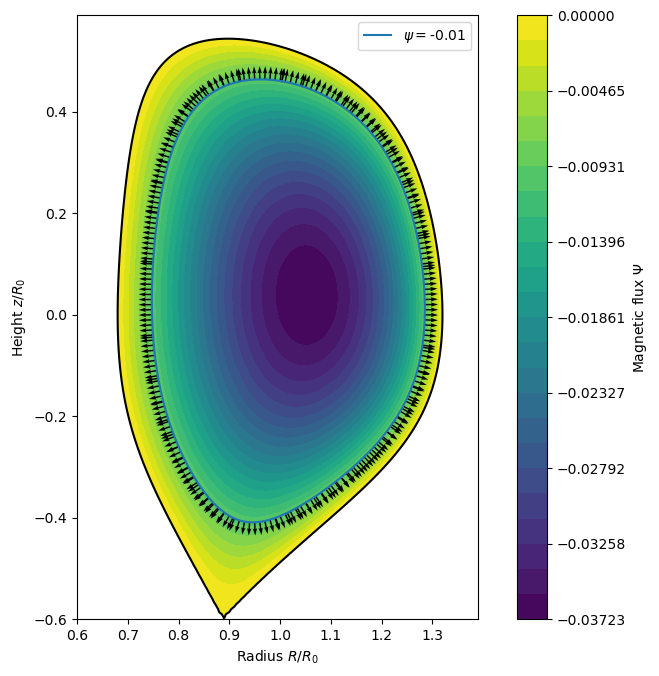

In [1]:
from plasmapy.particles import IonizationStateCollection

all_species = IonizationStateCollection(
    {
        "H": [0, 1],
        #      "D": [0, 1],   raises ParticleError, why?
        "C": [0, 0, 0, 0, 0, 0, 1],
    },
    n0=1e20 * u.m ** -3,
    abundances={"H": 1, "C": 0.08},
    T_e=10 * u.eV,
)

## `SymbolicEquilibrium`

from plasmapy.plasma.symbolicequilibrium import SymbolicEquilibrium

params = {"aspect_ratio": 0.32, "A": -0.155, "elongation": 1.7, "triangularity": 0.33}
eq = SymbolicEquilibrium(**params, B0=5.2, config="single-null")
## `FluxSurface`

ax = eq.plot()
fs = flux_surface = eq.get_flux_surface(-0.01)
fs.plot(ax, n=True);

In [2]:
import itertools

from scipy import integrate
from tqdm.auto import tqdm

from plasmapy.transport.neoclassical import mu_hat

data = []
for (xmin, xmax, N, α, β) in tqdm(
    list(
        itertools.product(
            [0.0015, 0.015, 0.15, 0.00015],
            #     [0.015],
            #     [5],
            [10],
            [1000],
            #     [1000, 10000, 100],
            [1, 2, 3],
            [1, 2, 3],
        )
    )
):

    x = np.logspace(np.log10(xmin), np.log10(xmax), N)
    integral = mu_hat(a["H", all_species, fs, xmin=xmin, xmax=xmax, N=N)
    data.append(dict(xmin=xmin, xmax=xmax, integral=integral.si.value, N=N))
plt.yscale("log")
# plt.legend()

SyntaxError: invalid syntax (<ipython-input-2-b1448a9ffd99>, line 25)

In [ ]:
import pandas as pd

df = pd.DataFrame(data)
df.head()

In [ ]:
df.query("xmin== 0.00150 and xmax==10 and N==1000").plot.scatter(
    x="α", y="integral", c="β"
)

## n

In [ ]:
n = fs.Bvectors / np.linalg.norm(fs.Bvectors, axis=0)

## Curved plots

In [ ]:
def plot_on_curve(y):
    plt.scatter(fs.R, fs.Z, c=y, alpha=0.7)
    plt.gca().set_aspect("equal")
    plt.colorbar()


plot_on_curve(fs.Theta)

In [ ]:
plt.plot(fs.Theta, fs.R)
plt.plot(fs.Theta, fs.Z)

In [ ]:
np.gradient(fs.theta, fs.lp) * n

In [ ]:
fs.theta

In [ ]:
fs.flux_surface_average(fs.Bp * np.gradient(fs.theta, fs.lp),)

In [ ]:
plt.plot(fs.lp, np.gradient(fs.theta, fs.lp))

## Toroidal flux

In [ ]:
R, Z = eq.symbols

Okay. I think I'm starting to get it.

I need to calculate the toroidal and poloidal flux from this.

The toroidal flux...

also,

> $\sqrt{g}$ is the Jacobian of the transformation from cylindrical coordinates to flux coordinates,

So this would be... $(R, Z, \phi) \to (\psi, \theta, \phi)$...

In [ ]:
fs.theta

In [ ]:
eq.Bphifunc(fs.R, fs.Z)

In [ ]:
eq.psisym

In [ ]:
fs.Bphivals

# Appendix B

### F_m and its unknown values

In [ ]:
Theta = fs.Theta
B20 = fs.Brvals * fs.Bprimervals + fs.Bzvals * fs.Bprimezvals
plt.plot(fs.lp, B20)

# B17
Bprimevectors = np.stack((fs.Bprimervals, fs.Bprimezvals))

under_average_B17 = np.array(
    [np.dot(ni, Bpi) ** 2 for (ni, Bpi) in zip(fs.n.T, Bprimevectors.T)]
)
plt.plot(fs.lp, under_average_B17)
B2mean = fs.flux_surface_average(fs.B2)
B17 = fs.flux_surface_average(under_average_B17) / B2mean

In [ ]:
num_m = 10000


from plasmapy.transport.neoclassical import F_m

# optimization = optimize.minimize_scalar(optimizer)
mrange = range(1, 2 * num_m)
F_ms = np.array([F_m(m, fs) for m in mrange])

In [ ]:
cumsum = np.cumsum(F_ms)

plt.plot(cumsum - B17, "bo--", label=r"$\sum_m F_m -$ B17")
# plt.axhline(0, color="black"
#            )
# plt.yscale("log")
# plt.xticks(mrange)
plt.legend()

So this probably sucks as a solution, a little.

In [ ]:
from plasmapy.transport.neoclassical import K_ps_ai

K_ps_ai(1, 1, a, all_species, fs, g=optimization.x, m_max=100)

In [ ]:
from plasmapy.formulary.neoclassical import K_B_ai

In [ ]:
K_B_ai(1, 1, a, all_species, fs)

$$[K_B^{ai}] = \frac{1}{1} \frac{[\nu_{D,ai}]}{1}$$

$$[\nu_{D,ai}] = s^{-1}$$

In [ ]:
from plasmapy.formulary.neoclassical import ν_T_ai

ν_T_ai(1, 1, a, all_species)

In [ ]:
from plasmapy.formulary.neoclassical import mu_hat, ωm

In [ ]:
from plasmapy.formulary import thermal_speed

## \nu_T_ai

In [ ]:
from scipy.special import erf

from plasmapy.formulary import thermal_speed
from plasmapy.formulary.mathematics import Chandrasekhar_G
from plasmapy.formulary.neoclassical import (
    effective_momentum_relaxation_rate,
    xab_ratio,
    ξ,
)

x = np.logspace(-3, 6, 5000)

ai = a[i]
prefactor = 3 * np.pi ** 0.5 / 4 * ξ(a)[i] / ai.number_density / ai.ion.mass


def gen():
    for b in all_species:
        if b.base_particle != a.base_particle:  # TODO is not should work
            x_over_xab = x / xab_ratio(a, b).si.value
            part1 = erf(x_over_xab) - 3 * Chandrasekhar_G(x_over_xab) / x ** 3
            part2 = 4 * (a.T_e / b.T_e + xab_ratio(a, b) ** -2)  # TODO adjust ratios
            part2full = part2 * Chandrasekhar_G(x_over_xab) / x
            yield (part1 + part2full) * effective_momentum_relaxation_rate(a, b)


result = prefactor * sum(gen())

In [ ]:
from plasmapy.formulary.mathematics import Chandrasekhar_G
from plasmapy.formulary.neoclassical import K_B_ai, pitch_angle_diffusion_rate

x = np.logspace(np.log10(xmin), 6, 5000)
ν_D_ai = pitch_angle_diffusion_rate(x, 1, a, all_species)
k = K_B_ai(x, 1, a, all_species, flux_surface)
g = Chandrasekhar_G(x)
plt.loglog(x, k)
x = np.logspace(-3, 6, 5000)
plt.loglog(x, ν_T_ai(x, i, a, all_species))

## K_ps_ai

In [ ]:
ai = a[i]
ν = ν_T_ai(x, i, a, all_species)

flux_surface = fs
# g = optimization.x
g = 1
m_max = 100
m = np.arange(1, m_max + 1)
F = F_m(m[:, np.newaxis], flux_surface, g=g)  # TODO replace
ω = ωm(x, m[:, np.newaxis], a, flux_surface)
B10 = (
    1.5 * (ν / ω) ** 2
    - 9 / 2 * (ν / ω) ** 4
    + (1 / 4 + (3 / 2 + 9 / 4 * (ν / ω) ** 2) * (ν / ω) ** 2)
    * (2 * ν / ω)
    * np.arctan(ω / ν).si.value
)
print(F.shape, B10.shape)
onepart = F[:, np.newaxis] * B10
full_sum = np.sum(onepart / ν, axis=0)
print(f"{full_sum=}")

out = 3 / 2 * thermal_speed(a.T_e, a.base_particle) ** 2 * x ** 2 * full_sum / u.m ** 2

plt.loglog(x, out)

In [ ]:
Y = np.logspace(-5, 2, 1000)
ν = ν_T_ai(Y, i, a, all_species)
plt.loglog(Y, ν)

In [ ]:
ν_T_ai(Y[ν < 0][0], i, a, all_species)

In [ ]:
ν_T_ai(0.1, i, a, all_species)

In [ ]:
from plasmapy.formulary.neoclassical import _integrand, K

x = np.logspace(np.log10(0.0015), 3, 10000)
kout = K(x, 1, a, all_species, fs)
kpout = K_ps_ai(x, 1, a, all_species, fs)
kbout = K_B_ai(x, 1, a, all_species, fs)
integrand = _integrand(x, 0, 0, 1, a, all_species, fs)
plt.loglog(x, kout, "o", label="K", alpha=0.5)
plt.loglog(x, kpout, "o", label="K_ps", alpha=0.5)
plt.loglog(x, kbout, "o", label="K_B", alpha=0.5)
plt.legend()

But this seems to average out in the end:

In [ ]:
x = np.logspace(np.log10(0.0015), 1.1, 10000)
for α in range(3):
    for β in range(4):
        integrand = _integrand(x, α, β, 1, a, all_species, fs)
        plt.plot(x, integrand, "o", label=f"{α=} {β=}", alpha=0.1)
plt.legend(loc="best")

In [ ]:
x = np.logspace(np.log10(0.0005), 0.6, 10000)
fig, axes = plt.subplots(3, 3, sharex=True)
for α in range(3):
    for β in range(3):
        integrand = _integrand(x, α, β, 1, a, all_species, fs)
        axes[α, β].plot(x, integrand)
        axes[α, β].set_title(f"{α=} {β=}")
# plt.legend(loc='best')